<a href="https://colab.research.google.com/github/Neo-glitch/kaggle_competitions/blob/main/tabular_series_oct_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-oct-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-oct-2022/train_9.csv
/kaggle/input/tabular-playground-series-oct-2022/train_3.csv
/kaggle/input/tabular-playground-series-oct-2022/train_4.csv
/kaggle/input/tabular-playground-series-oct-2022/test_dtypes.csv
/kaggle/input/tabular-playground-series-oct-2022/train_8.csv
/kaggle/input/tabular-playground-series-oct-2022/train_dtypes.csv
/kaggle/input/tabular-playground-series-oct-2022/train_5.csv
/kaggle/input/tabular-playground-series-oct-2022/train_2.csv
/kaggle/input/tabular-playground-series-oct-2022/test.csv
/kaggle/input/tabular-playground-series-oct-2022/train_0.csv
/kaggle/input/tabular-playground-series-oct-2022/train_7.csv
/kaggle/input/tabular-playground-series-oct-2022/train_1.csv
/kaggle/input/tabular-playground-series-oct-2022/train_6.csv
/kaggle/input/tpsoct22-feather-files/train_5.feather
/kaggle/input/tpsoct22-feather-files/test.feather
/kaggle/input/tpsoct22-feat

**Import needed libraries**

In [ ]:
# we will be working with compressed feather files, thanks to "ŞAFAK TÜRKELI"
# !pip install dask_ml

import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
# from lgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate

# import dask.dataframe as dd
# import dask_ml

**Load the data**

In [ ]:
# helper function to help optimize our memory by converting numerical col dtypes to min dtype needed for work
def optimize_memory_usage(df, show_result = False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int": 
                # if col type is int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else :
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")
    
    end_mem = df.memory_usage().sum() / 1024**2
    
    if(show_result):
        print("Memory usage was optimized from {:5.2f} Mb to {:5.2f}".format(start_mem, end_mem))
    return df

In [ ]:
train = optimize_memory_usage(pd.read_feather("../input/tpsoct22-feather-files/train_0.feather").sample(frac = 0.21), True)
for i in range(1, 10):
    train = pd.concat([train, optimize_memory_usage(pd.read_feather(f"../input/tpsoct22-feather-files/train_{i}.feather").sample(frac = 0.21), True)])
    gc.collect()

Memory usage was optimized from 213.51 Mb to 55.10
Memory usage was optimized from 215.43 Mb to 55.60
Memory usage was optimized from 211.13 Mb to 54.49
Memory usage was optimized from 210.05 Mb to 54.21
Memory usage was optimized from 210.37 Mb to 54.29
Memory usage was optimized from 207.98 Mb to 53.67
Memory usage was optimized from 205.02 Mb to 52.91
Memory usage was optimized from 209.56 Mb to 54.08
Memory usage was optimized from 213.75 Mb to 55.16
Memory usage was optimized from 208.88 Mb to 53.91


In [ ]:
gc.collect()
train.head(3)

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
1861979,638,638006,-64.500000,-65.312500,20.140625,27.265625,-34.218750,-15.453125,-18.421875,-64.7500,...,-4.332031,0.0,-6.296875,-6.597656,-7.332031,-4.332031,-1,NaN,0,0
1088030,369,369008,-113.750000,52.875000,-99.000000,5.695312,10.101562,30.953125,5.113281,68.5625,...,-0.148560,0.0,0.000000,-1.348633,-9.335938,-8.867188,0,A,0,0
1300769,442,442003,-3.738281,-30.671875,-87.375000,6.949219,43.375000,-53.093750,0.156372,-23.6875,...,-1.824219,0.0,-9.664062,0.000000,0.000000,0.000000,4,B,0,1


**Done Loading Data now time for Quick EDA(could later load just a small portion of data and do proper EDA)**

from data we saw that `game_num`, `event_id`, `event_time`, `player_scoring_next`, `team_scoring_next` where just in train data and not in test.
also this are not part of our label, so drop them and help save us space


In [ ]:
train = train.drop(columns = ["game_num", 'event_id', 'event_time', 'player_scoring_next', 'team_scoring_next'])

gc.collect()

0

In [ ]:
train.head()

,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,p0_vel_x,...,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,team_A_scoring_within_10sec,team_B_scoring_within_10sec
1861979,-65.312500,20.140625,27.265625,-34.218750,-15.453125,-18.421875,-64.750000,-38.281250,0.340332,8.742188,...,-0.317139,12.156250,-4.332031,0.000000,-6.296875,-6.597656,-7.332031,-4.332031,0,0
1088030,52.875000,-99.000000,5.695312,10.101562,30.953125,5.113281,68.562500,-63.812500,0.340088,-11.640625,...,0.005199,88.062500,-0.148560,0.000000,0.000000,-1.348633,-9.335938,-8.867188,0,0
1300769,-30.671875,-87.375000,6.949219,43.375000,-53.093750,0.156372,-23.687500,-102.000000,3.023438,21.484375,...,-0.314941,11.375000,-1.824219,0.000000,-9.664062,0.000000,0.000000,0.000000,0,1
645306,-78.625000,-27.125000,29.890625,-17.234375,-40.843750,12.046875,10.359375,-81.500000,0.340088,-23.390625,...,0.294189,0.000000,-6.265625,0.000000,-3.554688,-3.318359,-3.925781,0.000000,0,0
48734,55.187500,-15.125000,26.687500,21.468750,-29.312500,7.582031,-7.910156,31.890625,2.294922,-42.312500,...,-2.271484,27.421875,0.000000,-7.128906,0.000000,-1.858398,0.000000,-3.025391,0,0


In [ ]:
# find is any nan rows(will be replaced later)
# all p columns are nan when player is demolished or will respawn soon
# train_df.isnull().sum().compute()

train.isnull().sum()

ball_pos_x                         0
ball_pos_y                         0
ball_pos_z                         0
ball_vel_x                         0
ball_vel_y                         0
ball_vel_z                         0
p0_pos_x                       39478
p0_pos_y                       39478
p0_pos_z                       39478
p0_vel_x                       39478
p0_vel_y                       39478
p0_vel_z                       39478
p0_boost                       39478
p1_pos_x                       39784
p1_pos_y                       39784
p1_pos_z                       39784
p1_vel_x                       39784
p1_vel_y                       39784
p1_vel_z                       39784
p1_boost                       39784
p2_pos_x                       39729
p2_pos_y                       39729
p2_pos_z                       39729
p2_vel_x                       39729
p2_vel_y                       39729
p2_vel_z                       39729
p2_boost                       39729
p

In [ ]:
# function to fillNan values with 0 since player is dead or will soon respawn
def fill_null(df):
#     cols = [
#     "p0_pos_x","p1_pos_x","p2_pos_x","p3_pos_x","p4_pos_x","p5_pos_x",
#     "p0_pos_y","p1_pos_y","p2_pos_y","p3_pos_y","p4_pos_y","p5_pos_y",
#     "p0_pos_z","p1_pos_z","p2_pos_z","p3_pos_z","p4_pos_z","p5_pos_z",
    
#     "p0_vel_x","p1_vel_x","p2_vel_x","p3_vel_x","p4_vel_x","p5_vel_x",
#     "p0_vel_y","p1_vel_y","p2_vel_y","p3_vel_y","p4_vel_y","p5_vel_y",
#     "p0_vel_z","p1_vel_z","p2_vel_z","p3_vel_z","p4_vel_z","p5_vel_z",
    
#     'p0_boost','p1_boost','p2_boost','p3_boost','p4_boost','p5_boost'
#     ]
    
#     for col in cols:
#         df[col] = df[col].fillna(0)
    
    # rather than filling nan rows with constant value of 0
    # lets drop it as it helps to also save us memory
    df = df.dropna()
    
#     del cols
    gc.collect()
   
    return df

gc.collect()

46

In [ ]:
train = train.dropna()
gc.collect()

13

In [ ]:
train.isnull().sum()

ball_pos_x                     0
ball_pos_y                     0
ball_pos_z                     0
ball_vel_x                     0
ball_vel_y                     0
ball_vel_z                     0
p0_pos_x                       0
p0_pos_y                       0
p0_pos_z                       0
p0_vel_x                       0
p0_vel_y                       0
p0_vel_z                       0
p0_boost                       0
p1_pos_x                       0
p1_pos_y                       0
p1_pos_z                       0
p1_vel_x                       0
p1_vel_y                       0
p1_vel_z                       0
p1_boost                       0
p2_pos_x                       0
p2_pos_y                       0
p2_pos_z                       0
p2_vel_x                       0
p2_vel_y                       0
p2_vel_z                       0
p2_boost                       0
p3_pos_x                       0
p3_pos_y                       0
p3_pos_z                       0
p3_vel_x  

In [ ]:
gc.collect()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218865 entries, 1861979 to 2053613
Data columns (total 56 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   ball_pos_x                   float16
 1   ball_pos_y                   float16
 2   ball_pos_z                   float16
 3   ball_vel_x                   float16
 4   ball_vel_y                   float16
 5   ball_vel_z                   float16
 6   p0_pos_x                     float16
 7   p0_pos_y                     float16
 8   p0_pos_z                     float16
 9   p0_vel_x                     float16
 10  p0_vel_y                     float16
 11  p0_vel_z                     float16
 12  p0_boost                     float16
 13  p1_pos_x                     float16
 14  p1_pos_y                     float16
 15  p1_pos_z                     float16
 16  p1_vel_x                     float16
 17  p1_vel_y                     float16
 18  p1_vel_z                     float16

<AxesSubplot:ylabel='Density'>

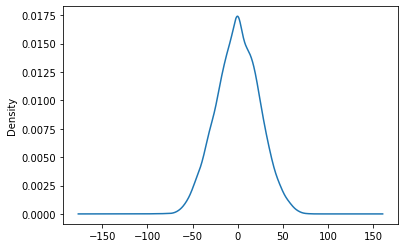

In [ ]:
# seems to have a normal distribution, same thing for vel_y and vel_z
train["ball_vel_x"].sample(frac = 0.0005).plot(kind="kde")

<AxesSubplot:ylabel='Density'>

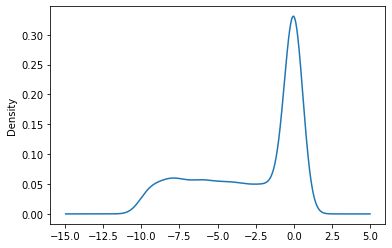

In [ ]:
# similar distribution for all boost_timer cols
train["boost1_timer"].sample(frac = 0.0005).plot(kind="kde")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='team_A_scoring_within_10sec', ylabel='count'>

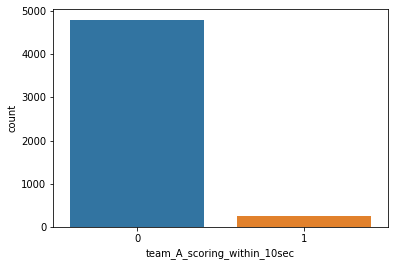

In [ ]:
# seen that chance of scoring is less than chance of not scoring. which is quite normal
sns.countplot(train["team_A_scoring_within_10sec"].sample(frac = 0.0005))

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='team_B_scoring_within_10sec', ylabel='count'>

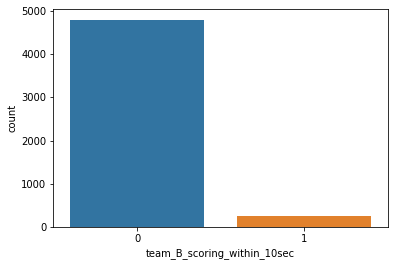

In [ ]:
# seen that chance of scoring is less than chance of not scoring. which is quite normal
sns.countplot(train["team_B_scoring_within_10sec"].sample(frac = 0.0005))

<AxesSubplot:>

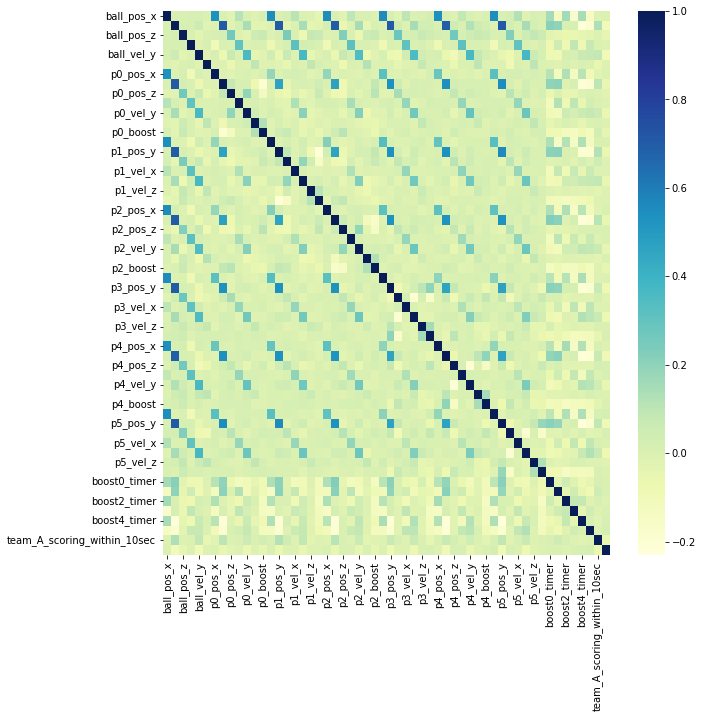

In [ ]:
plt.figure(figsize = (10, 10))
sns.heatmap(train.sample(frac = 0.0005).corr(), cmap ="YlGnBu")

In [ ]:
train.head()

,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,p0_vel_x,...,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,-0.0,0.0,1.854492,-0.0,0.0,0.0,41.81250,-51.93750,0.340088,5.636719,...,-0.000200,22.343750,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,-0.0,0.0,1.854492,-0.0,0.0,0.0,42.25000,-52.43750,0.340088,5.289062,...,0.000200,30.625000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,-0.0,0.0,1.854492,-0.0,0.0,0.0,43.21875,-54.06250,1.146484,5.687500,...,6.210938,26.890625,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,-0.0,0.0,1.854492,-0.0,0.0,0.0,43.90625,-55.21875,1.593750,10.593750,...,4.933594,23.375000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,-0.0,0.0,1.854492,-0.0,0.0,0.0,44.96875,-57.09375,2.072266,10.632812,...,1.325195,19.843750,0.0,0.0,0.0,0.0,0.0,0.0,0,0


### Feature Engineering

In [ ]:
# function to get ball distance from players location    
def get_new_features(df):
    for i in range(6):
        # done this way to get absolute values
        df[f"p{i}_ball_distance"] = ((df["ball_pos_x"] - df[f"p{i}_pos_x"]) **2 + \
        (df["ball_pos_y"] - df[f"p{i}_pos_y"]) **2 + \
        (df["ball_pos_z"] - df[f"p{i}_pos_z"]) **2) ** 0.5
        
        # if player in this x and y cordinates which is pos of BigBoostOrb
        # and boost timer is 0 then set okayer boost to 100
        x_cord_condition = [-61.4, 61.4, -71.7, 71.7, -61.4, 61.4]
        y_cord_condition = [-81.9, -81.9, 0, 0, 81.9, 81.9]
        boost_timer_condition = 0
        
        # pandas way of doing dask code below
        df.loc[(df[f"p{i}_pos_x"].isin(x_cord_condition)) & (df[f"p{i}_pos_y"].isin(y_cord_condition)) \
              & (df[f"boost{i}_timer"] == boost_timer_condition), f"p{i}_boost"] = 100

        # dask way of doing code above
#         df[f"p{i}_boost"] = df[f"p{i}_boost"].mask((df[f"p{i}_pos_x"].isin(x_cord_condition)) & (df[f"p{i}_pos_y"].isin(y_cord_condition)) \
#               & (df[f"boost{i}_timer"] == boost_timer_condition), 100)
        
        
        del x_cord_condition
        del y_cord_condition
        del boost_timer_condition
        gc.collect()
    
        
    return df

In [ ]:
train = get_new_features(train)

In [ ]:
gc.collect()
train.head()

,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,p0_vel_x,...,boost4_timer,boost5_timer,team_A_scoring_within_10sec,team_B_scoring_within_10sec,p0_ball_distance,p1_ball_distance,p2_ball_distance,p3_ball_distance,p4_ball_distance,p5_ball_distance
1861979,-65.312500,20.140625,27.265625,-34.218750,-15.453125,-18.421875,-64.750000,-38.281250,0.340332,8.742188,...,-7.332031,-4.332031,0,0,64.31250,78.500000,90.562500,28.875000,57.687500,56.46875
1088030,52.875000,-99.000000,5.695312,10.101562,30.953125,5.113281,68.562500,-63.812500,0.340088,-11.640625,...,-9.335938,-8.867188,0,0,38.90625,40.531250,4.460938,165.750000,7.144531,218.75000
1300769,-30.671875,-87.375000,6.949219,43.375000,-53.093750,0.156372,-23.687500,-102.000000,3.023438,21.484375,...,0.000000,0.000000,0,1,16.68750,25.609375,42.281250,19.125000,98.062500,20.65625
645306,-78.625000,-27.125000,29.890625,-17.234375,-40.843750,12.046875,10.359375,-81.500000,0.340088,-23.390625,...,-3.925781,0.000000,0,0,108.43750,51.156250,125.687500,30.453125,90.812500,78.62500
48734,55.187500,-15.125000,26.687500,21.468750,-29.312500,7.582031,-7.910156,31.890625,2.294922,-42.312500,...,0.000000,-3.025391,0,0,82.37500,51.312500,34.968750,85.250000,97.750000,24.84375


**Model Training and Making Predictions Simultaneously, due to low ram**


In [ ]:
gc.collect()
yA = train['team_A_scoring_within_10sec']
yB = train['team_B_scoring_within_10sec']

x = train.drop(columns = ["team_A_scoring_within_10sec", "team_B_scoring_within_10sec"])

x_test =  get_new_features(optimize_memory_usage(pd.read_csv("../input/tabular-playground-series-oct-2022/test.csv")))
x_test.fillna(0)
test_id = x_test["id"]
x_test.drop(columns = ["id"], inplace =True)
del train
gc.collect()

len(x.columns), len(x_test.columns)

(60, 60)

In [ ]:
len(x_test.index)

701143

In [ ]:
params = {'tree_method': 'gpu_hist',
          'n_estimators': 240,
          'max_depth': 8,
          'learning_rate': 0.1,
          'objective': 'binary:logistic',
         }

# used to train model for modelA and modelB
def train_model(x, y, x_test):
    gc.collect()
    roc_scores = []
    test_predictions_proba = []
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(x, y)):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = XGBClassifier(**params)
        model.fit(x_train, y_train)
        predictions_prob = model.predict_proba(x_val)[:, 1]
        score = roc_auc_score(y_val, predictions_prob)
        roc_scores.append(score)
        test_predictions_proba.append(model.predict_proba(x_test)[:, 1])
        print(f"Fold {fold + 1} \t\t AUC: {score}")
        
        del model
        del x_train
        del x_val
        del y_train
        del y_val
        gc.collect()
    
    print("Overall roc_auc_score: ", np.mean(roc_scores))
    return test_predictions_proba
        

In [ ]:
predictions_A = train_model(x, yA, x_test)

Fold 1 		 AUC: 0.779027311756058
Fold 2 		 AUC: 0.7818504998346956
Fold 3 		 AUC: 0.7805682857356466
Fold 4 		 AUC: 0.7800677951182263
Fold 5 		 AUC: 0.7802744514137218
Overall roc_auc_score:  0.7803576687716697


In [ ]:
gc.collect()
predictions_B = train_model(x, yB, x_test)

Fold 1 		 AUC: 0.7805460887859448
Fold 2 		 AUC: 0.7825103336671114
Fold 3 		 AUC: 0.7801946960288043
Fold 4 		 AUC: 0.7803223799993165
Fold 5 		 AUC: 0.7803999908322536
Overall roc_auc_score:  0.7807946978626861


In [ ]:
# viz one prediction result
# each element in predictions A match to model predictions when trained on fold 1
predictions_A[0]

array([0.03206485, 0.05724065, 0.02291578, ..., 0.0778046 , 0.00990501,
       0.05092934], dtype=float32)

In [ ]:
predictions_mean_A = np.mean(predictions_A, axis = 0)

In [ ]:
predictions_mean_B = np.mean(predictions_B, axis = 0)

In [ ]:
submission = pd.DataFrame({"id": test_id,
    "team_A_scoring_within_10sec": predictions_mean_A,
    "team_B_scoring_within_10sec": predictions_mean_B})

In [ ]:
submission.to_csv("submission_on_20%_sample_of_whole_data_tweak.csv", index = False)

In [ ]:
del predictions_mean_A
del predictions_mean_B
del submission
del predictions_A
del predictions_B

**Come back later to find out if there's any other feature combination**